In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tqdm.auto import tqdm
import torch.nn.functional as F
import os
import pandas as pd
import skimage.io
from skimage.transform import resize
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

data_, attrs = fetch_dataset()

data_loader_ = DataLoader(data_, batch_size = 64, shuffle = True)

images not found, donwloading...


--2024-06-10 19:51:34--  http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108761145 (104M) [application/x-gzip]
Saving to: 'tmp.tgz'

     0K .......... .......... .......... .......... ..........  0%  283K 6m16s
    50K .......... .......... .......... .......... ..........  0%  474K 5m0s
   100K .......... .......... .......... .......... ..........  0%  426K 4m43s
   150K .......... .......... .......... .......... ..........  0%  310M 3m32s
   200K .......... .......... .......... .......... ..........  0%  520K 3m30s
   250K .......... .......... .......... .......... ..........  0%  768K 3m18s
   300K .......... .......... .......... .......... ..........  0% 1.28M 3m1s
   350K .......... .......... .......... .......... ..........  0%  476K 3m6s
   400K .......

extracting...
lfw-deepfunneled/AJ_Cook/AJ_Cook_0001.jpg
lfw-deepfunneled/AJ_Lamas/AJ_Lamas_0001.jpg
lfw-deepfunneled/Aaron_Eckhart/Aaron_Eckhart_0001.jpg
lfw-deepfunneled/Aaron_Guiel/Aaron_Guiel_0001.jpg
lfw-deepfunneled/Aaron_Patterson/Aaron_Patterson_0001.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0001.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0002.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0003.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0004.jpg
lfw-deepfunneled/Aaron_Pena/Aaron_Pena_0001.jpg
lfw-deepfunneled/Aaron_Sorkin/Aaron_Sorkin_0001.jpg
lfw-deepfunneled/Aaron_Sorkin/Aaron_Sorkin_0002.jpg
lfw-deepfunneled/Aaron_Tippin/Aaron_Tippin_0001.jpg
lfw-deepfunneled/Abba_Eban/Abba_Eban_0001.jpg
lfw-deepfunneled/Abbas_Kiarostami/Abbas_Kiarostami_0001.jpg
lfw-deepfunneled/Abdel_Aziz_Al-Hakim/Abdel_Aziz_Al-Hakim_0001.jpg
lfw-deepfunneled/Abdel_Madi_Shabneh/Abdel_Madi_Shabneh_0001.jpg
lfw-deepfunneled/Abdel_Nasser_Assidi/Abdel_Nasser_Assidi_0001.jpg
lfw-deepfunneled

--2024-06-10 19:53:18--  http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
Resolving www.cs.columbia.edu (www.cs.columbia.edu)... 128.59.11.206
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt [following]
--2024-06-10 19:53:18--  https://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14879205 (14M) [text/plain]
Saving to: 'lfw_attributes.txt'

     0K .......... .......... .......... .......... ..........  0%  415K 35s
    50K .......... .......... .......... .......... ..........  0%  829K 26s
   100K .......... .......... .......... .......... ..........  1%  834K 23s
   150K .......... .......... ..........

done


NameError: name 'skimage' is not defined

In [3]:
data = datasets.MNIST(root = '../data', train = True, download = True, transform= transforms.ToTensor())
data_loader = DataLoader(data, batch_size = 64, shuffle = True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15876863.80it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 463276.53it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4367355.84it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3284007.72it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [3]:

class VAE(nn.Module):
    
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 1, padding = 0),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (3,3), stride = 1, padding = 0), # 24x24
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2), # 12x12
            nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = (3,3), stride = 1, padding = 0),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = (3,3), stride = 1, padding = 0), # 8x8
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Flatten(),
        )
        self.encoder_fc = nn.Sequential(
            nn.Linear(in_features = 8*8*32, out_features = 2 * 100),
            nn.ReLU(),
            nn.BatchNorm1d(200),
            nn.Dropout(0.2),
            nn.Linear(in_features = 2*100, out_features = 2 * self.latent_dim),
        )
        
        self.decoder_fc = nn.Sequential(
            nn.Linear(in_features = self.latent_dim, out_features = 512),
            nn.ReLU(),
        )
        self.decoder_cv = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 8, out_channels = 32, kernel_size = (3,3), stride = 1, padding = 1), # 20x20
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels = 32, out_channels = 64, kernel_size = (2,2), stride = 2, padding = 0), # 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels = 64, out_channels = 64, kernel_size = (3,3), stride = 1, padding = 1), # 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels = 64, out_channels = 64, kernel_size = (5,5), stride = 1, padding = 0), # 20x20
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels = 64, out_channels = 64, kernel_size = (3,3), stride = 1, padding = 1), # 20x20
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels = 64, out_channels = 32, kernel_size = (5,5), stride = 1, padding = 0), # 24x24
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels = 32, out_channels = 1, kernel_size = (5,5), stride = 1, padding = 0), # 28x28
            nn.Sigmoid(),
        )
        
    def reparametrization(self, mu, log_var):
        eps = torch.randn_like(mu)
        
        return mu + eps * torch.exp(0.5 * log_var)
    
    def sample(self, z, label = 0):
#         label = F.one_hot(torch.Tensor([label]).long(), num_classes = 10).to(device)
#         z = torch.cat((z, label), 1)
        z = self.decoder_fc(z)
        z = z.reshape((z.shape[0], 8, 8, 8))
        z = self.decoder_cv(z)
        return z.reshape(-1, 28, 28, 1)
                      
    def forward(self, x, class_n):
        
        #x = self.flatten(x)
        
        x = self.encoder(x)
        # x = torch.cat((x, class_n), 1)
        x = self.encoder_fc(x)
        
        x = x.reshape(x.shape[0], 2, x.shape[1] // 2)
        
        mu = x[:, 0, :]
        log_var = x[:, 1, :]
        
        x = self.reparametrization(mu, log_var)
        #x = torch.cat((x, class_n), 1)
        x = self.decoder_fc(x)
        
        x = x.reshape((x.shape[0], 8, 8, 8))
        x = self.decoder_cv(x)
        return mu, log_var, x
    
    
class VAELOSS:
    def __init__(self):
        self.reconstruction_loss = nn.MSELoss(reduction="sum")
        
    def __call__(self, target, pred, mu, log_var, alpha = 1, betta = 1):
    
        first = self.reconstruction_loss(target, pred)
        second = 0.5 * torch.sum(torch.exp(log_var) + mu ** 2 - 1 - log_var)
        return alpha * first + betta * second


In [93]:

class VAEVAE(nn.Module):
    
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = (3,3), stride = 1, padding = 0), #62x62
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (3,3), stride = 1, padding = 0), # 60x60
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2), # 30x30
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = (3,3), stride = 1, padding = 0), #28x28
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (5,5), stride = 1, padding = 0), # 24x24
            nn.ReLU(),
            nn.BatchNorm2d(128),
            
            nn.MaxPool2d(2), # 30x30
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = (3,3), stride = 1, padding = 0), #10x10
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 1, padding = 0), # 8x8
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = (3,3), stride = 1, padding = 0), # 6x6
            nn.ReLU(),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = (3,3), stride = 1, padding = 0), # 4x4
            nn.ReLU(),
            nn.BatchNorm2d(32),
            
            nn.Flatten(),
        )
        self.encoder_fc = nn.Sequential(
            nn.Linear(in_features = 4*4*32, out_features =  100),
            nn.ReLU(),
            nn.BatchNorm1d(100),
            nn.Dropout(0.3),
            nn.Linear(in_features = 100, out_features = 2 * self.latent_dim),
        )
        
        self.decoder_fc = nn.Sequential(
            nn.Linear(in_features = self.latent_dim, out_features = 512),
            nn.ReLU(),
        )
        self.decoder_cv = nn.Sequential(
            #8x8
            nn.ConvTranspose2d(in_channels = 8, out_channels = 32, kernel_size = (3,3), stride = 1, padding = 0), # 10x10
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels = 32, out_channels = 64, kernel_size = (3,3), stride = 1, padding = 0), # 12x12
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels = 64, out_channels = 64, kernel_size = (2,2), stride = 2, padding = 0), # 24x24
            nn.ReLU(),
            
            nn.ConvTranspose2d(in_channels = 64, out_channels = 128, kernel_size = (3,3), stride = 1, padding = 0), # 26x26
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 1, padding = 0), # 28x28
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels = 64, out_channels = 64, kernel_size = (3,3), stride = 1, padding = 0), # 30x30
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels = 64, out_channels = 32, kernel_size = (2,2), stride = 2, padding = 0), # 60x60
            nn.ReLU(),
            
            nn.ConvTranspose2d(in_channels = 32, out_channels = 16, kernel_size = (3,3), stride = 1, padding = 0), # 62x62
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels = 16, out_channels = 3, kernel_size = (3,3), stride = 1, padding = 0), # 64x64
            nn.Sigmoid(),
        )
        
    def reparametrization(self, mu, log_var):
        eps = torch.randn_like(mu)
        
        return mu + eps * torch.exp(0.5 * log_var)
    
    def sample(self, z):
#         label = F.one_hot(torch.Tensor([label]).long(), num_classes = 10).to(device)
#         z = torch.cat((z, label), 1)
        z = self.decoder_fc(z)
        z = z.reshape((z.shape[0], 8, 8, 8))
        z = self.decoder_cv(z)
        return z.permute(0,2,3,1)
                      
    def forward(self, x):
        
        #x = self.flatten(x)
        
        x = self.encoder(x)
        # x = torch.cat((x, class_n), 1)
        x = self.encoder_fc(x)
        
        x = x.reshape(x.shape[0], 2, x.shape[1] // 2)
        
        mu = x[:, 0, :]
        log_var = x[:, 1, :]
        
        x = self.reparametrization(mu, log_var)
        #x = torch.cat((x, class_n), 1)
        x = self.decoder_fc(x)
        
        x = x.reshape((x.shape[0], 8, 8, 8))
        x = self.decoder_cv(x)
        return mu, log_var, x
    
    
class VAELOSS:
    def __init__(self):
        self.reconstruction_loss = nn.MSELoss(reduction="sum")
        
    def __call__(self, target, pred, mu, log_var, alpha = 1, betta = 1):
    
        first = self.reconstruction_loss(target, pred)
        second = 0.5 * torch.sum(torch.exp(log_var) + mu ** 2 - 1 - log_var)
        return alpha * first + betta * second


In [94]:
model = VAEVAE(64)
encoder = torch.nn.DataParallel(model, device_ids=(0,1))
model.to(device)
loss_fn = VAELOSS()
optim = torch.optim.Adam(model.parameters(), lr = 1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=50, gamma=0.1)

  0%|          | 0/100 [00:00<?, ?it/s]

16738.24010253906


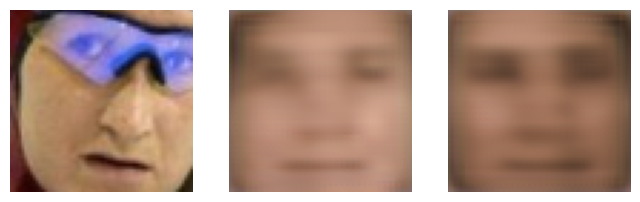

15790.566259765625


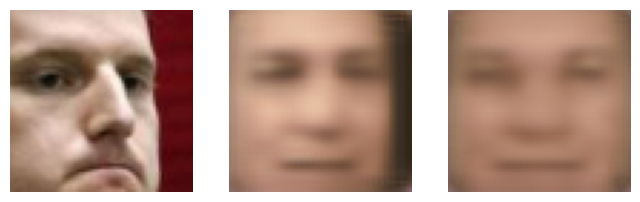

15069.766196289063


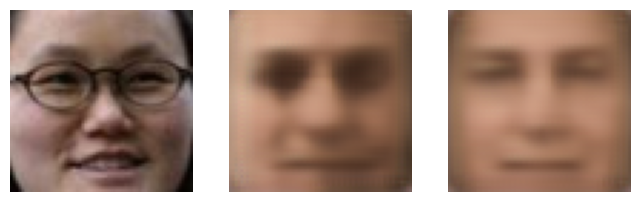

14455.574892578124


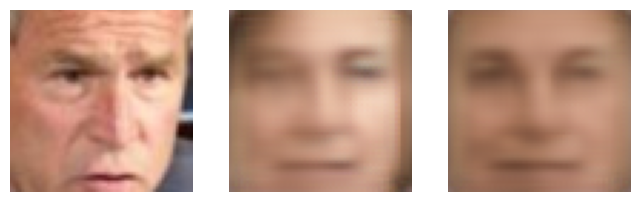

14045.7174609375


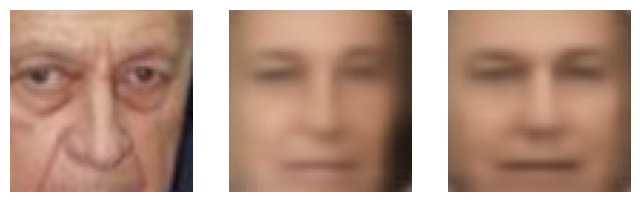

13691.390659179688


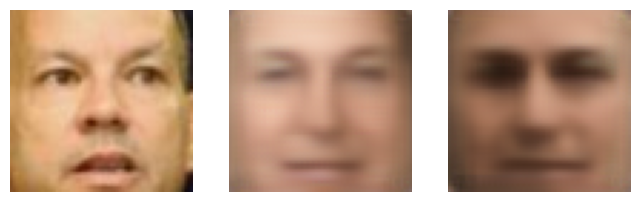

13455.180971679687


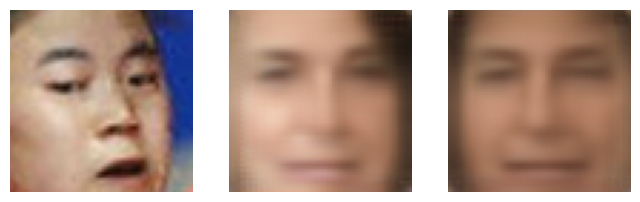

12999.157255859374


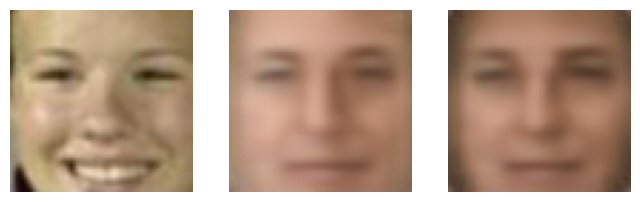

12910.403681640624


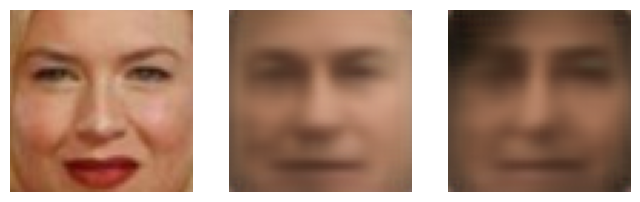

12652.827138671875


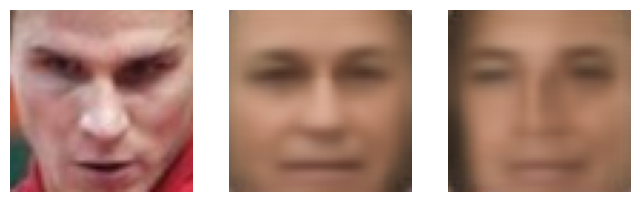

12508.144116210937


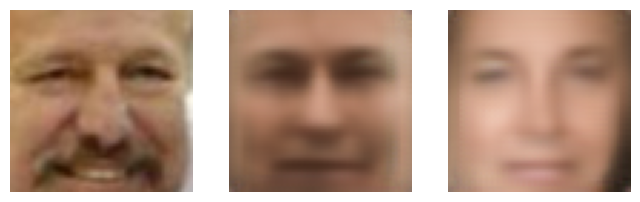

12453.154819335938


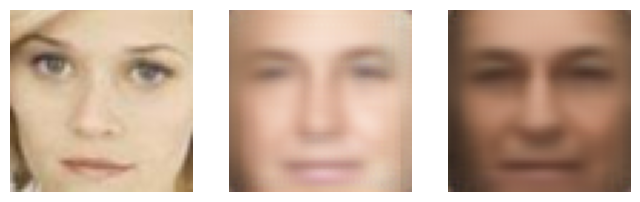

12122.587055664062


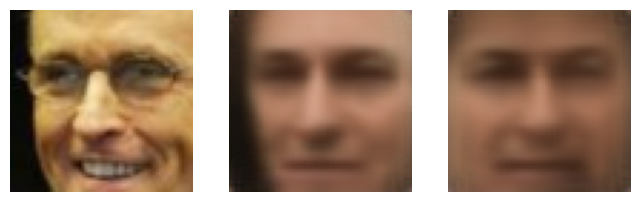

12010.6906640625


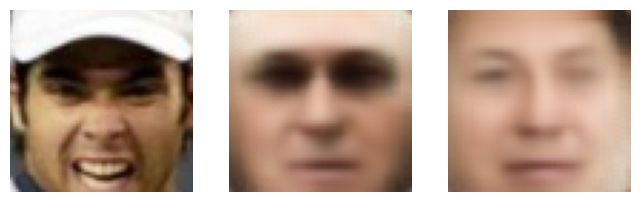

12044.652734375


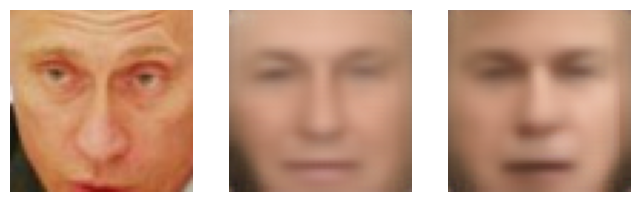

11849.825678710937


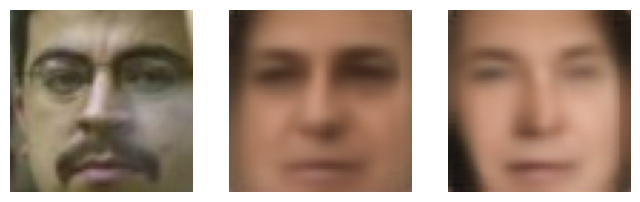

11889.96283203125


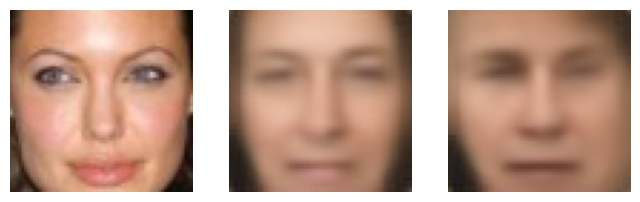

11680.630522460937


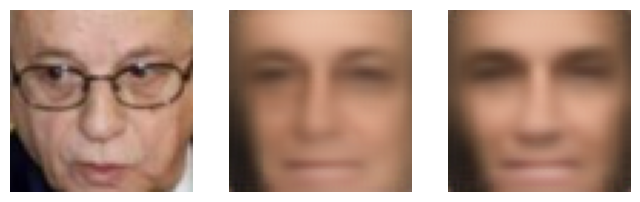

11696.297348632812


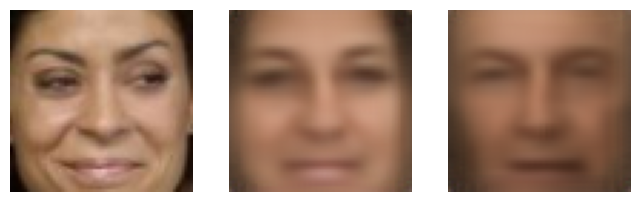

11652.183930664063


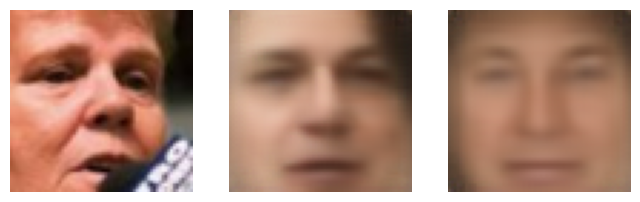

11615.517690429688


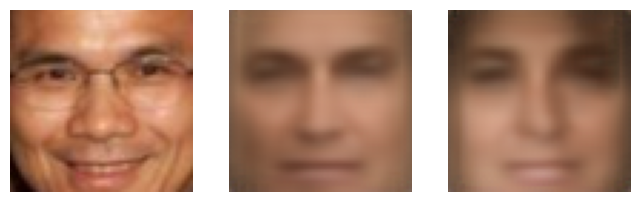

11615.000673828124


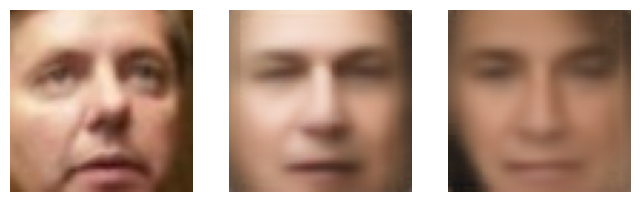

11574.894140625


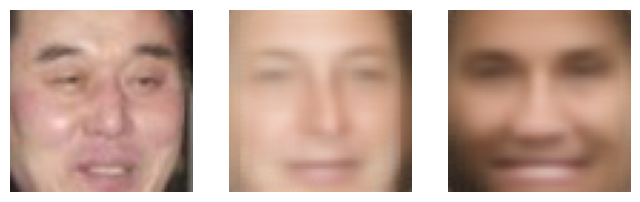

11749.966411132813


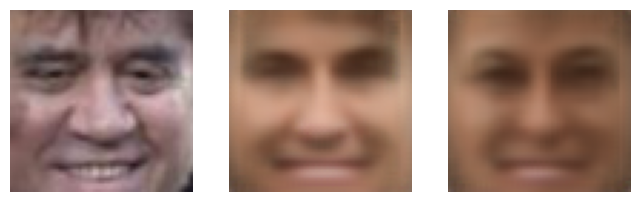

11349.30608642578


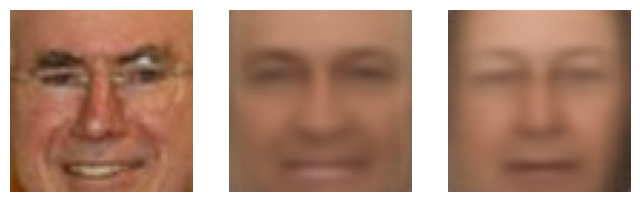

11444.61375


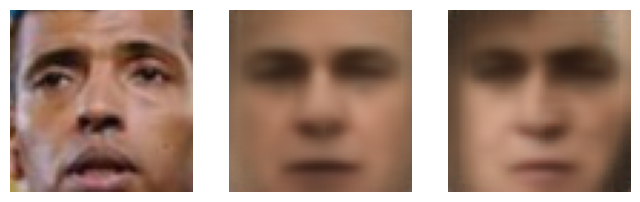

11459.310581054688


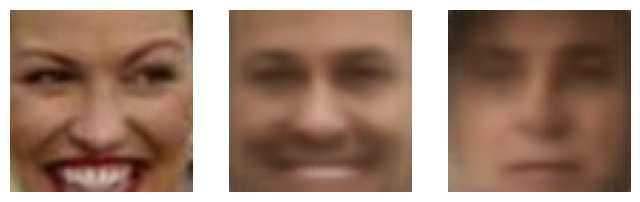

11379.610087890625


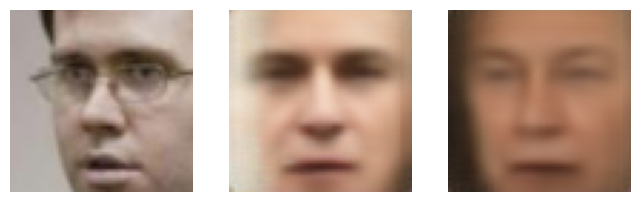

11205.828139648438


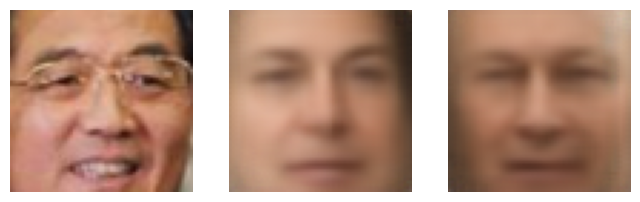

11365.123134765625


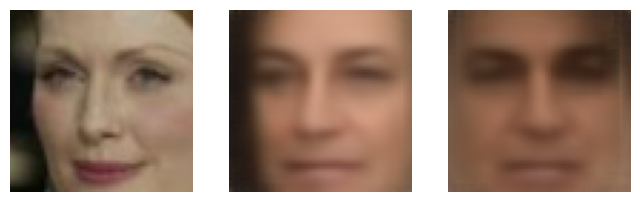

11198.717807617188


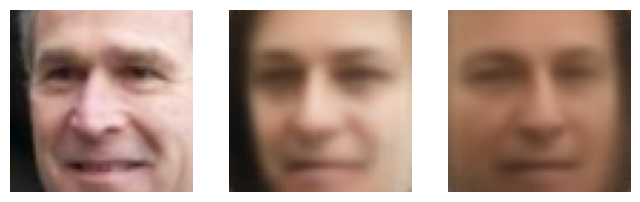

11101.572048339844


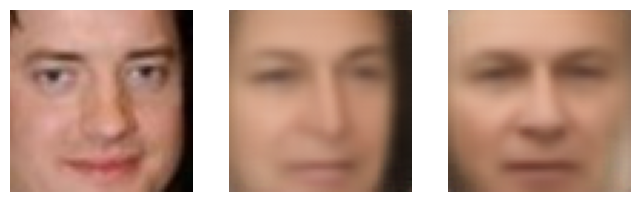

11159.612475585938


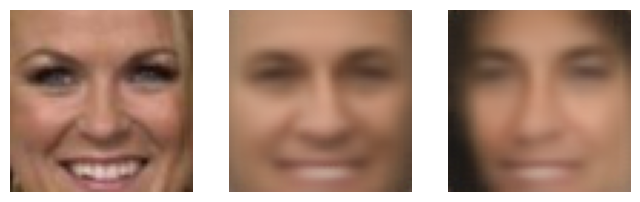

11187.36341796875


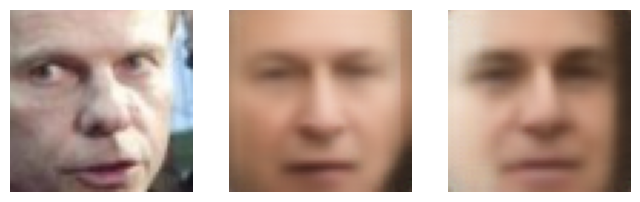

11195.544951171874


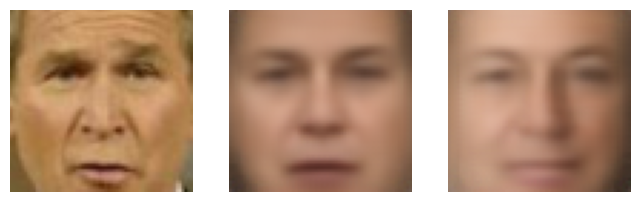

11135.414580078124


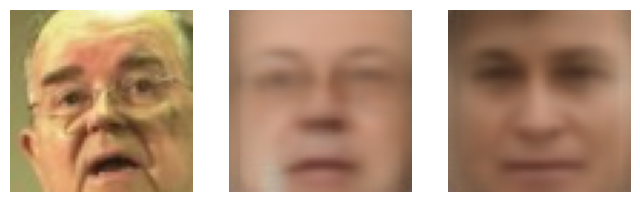

11188.949143066406


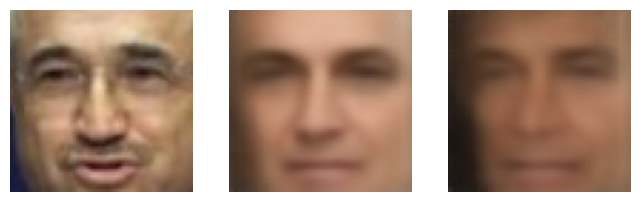

11050.168051757813


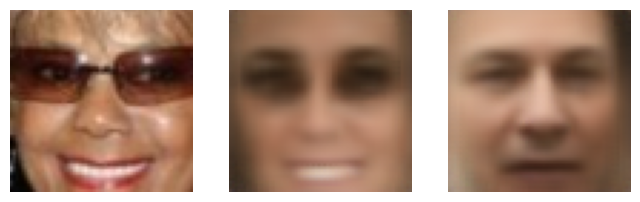

11077.133701171875


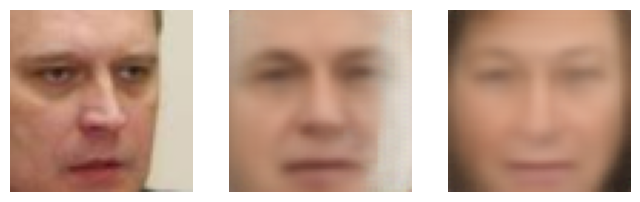

10937.492236328126


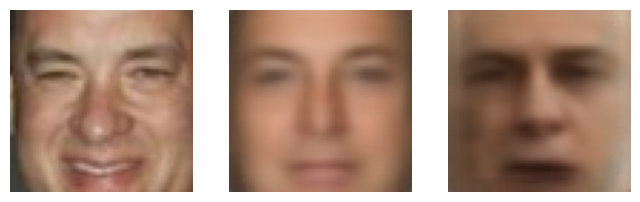

11093.591137695312


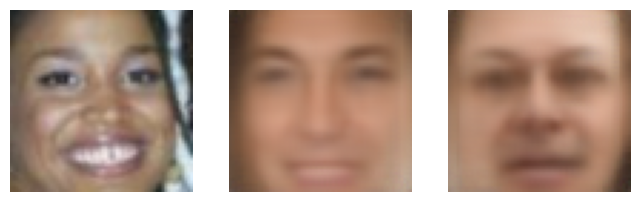

11000.930830078125


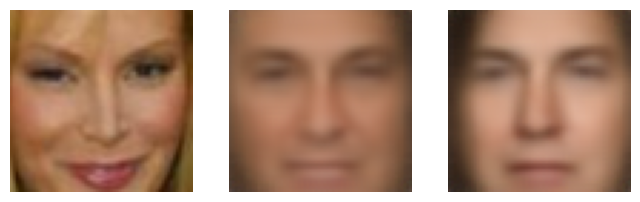

10995.01685546875


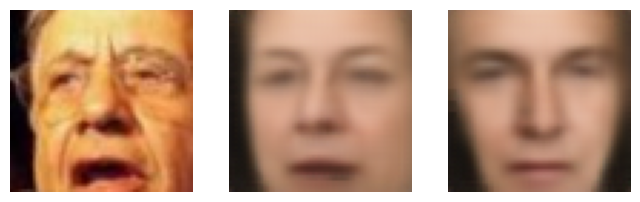

11006.933671875


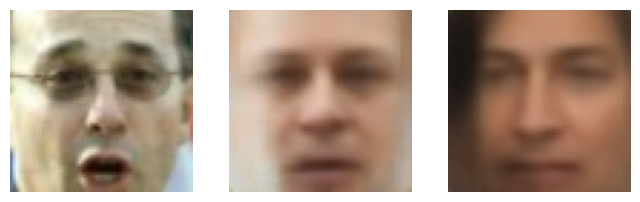

10936.301567382812


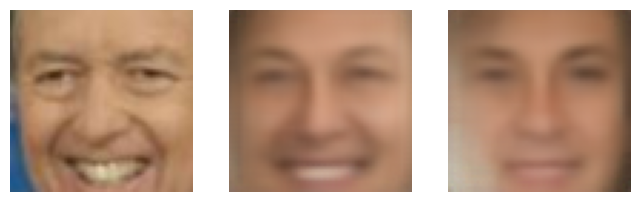

10955.301225585938


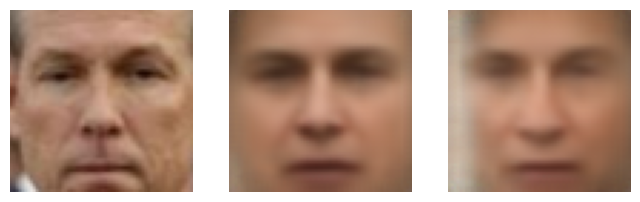

10946.237797851563


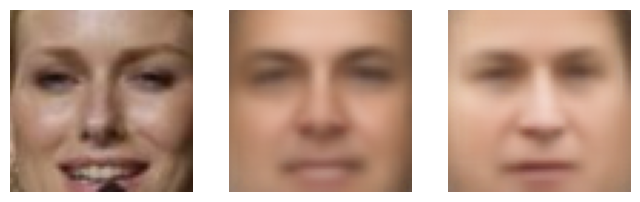

10949.01


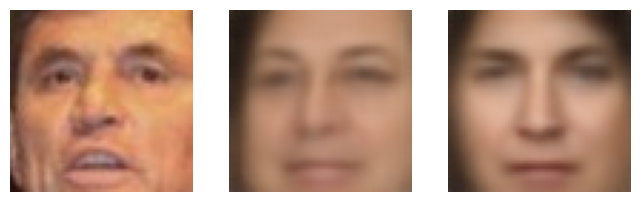

10949.73310546875


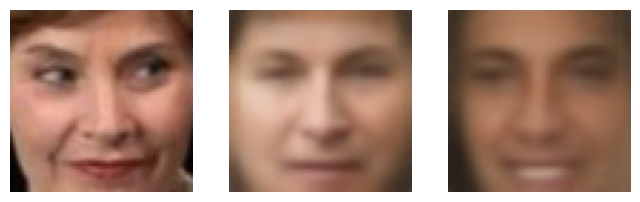

10583.052548828126


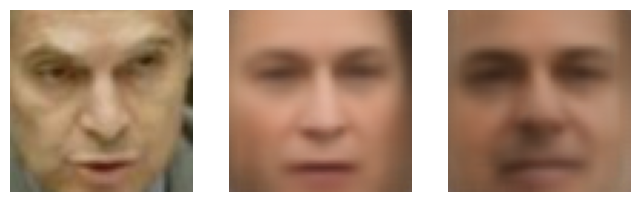

KeyboardInterrupt: 

In [96]:
num_epochs = 100
losses = []

for epoch in tqdm(range(1, num_epochs + 1)):
    for index, data in enumerate(data_loader_):
        
        img = data.to(device).permute(0,3,1,2).float()
        model.train()
        #label = F.one_hot(data[1], num_classes = 10).to(device)
        #print(img.shape,img.permute(0, 3, 1, 2).shape )
        mu, log_var, reconstructed_img = model(img)
        
        loss_item = loss_fn(img, reconstructed_img, mu, log_var, alpha = 1.2, betta = 1)
        
        model.zero_grad()
        
        loss_item..sum().backward()
        
        optim.step()
        
        losses.append(loss_item.item())
        
    scheduler.step()
     
    print(np.mean(losses[-100:]))
    plt.figure(figsize=(8, 8))
    
    plt.subplot(1,3,1)
    plt.imshow(img[0].cpu().detach().permute(1,2,0).numpy())
    plt.axis('off')
    
    plt.subplot(1,3,2)
    plt.imshow(reconstructed_img[0].cpu().detach().permute(1,2,0).numpy())
    plt.axis('off')
        
    plt.subplot(1,3,3)
    z = torch.randn((1, 64))
    model.eval()
    new_image = model.sample(z.to(device))
    plt.imshow(new_image[0].cpu().detach().numpy(), cmap = 'gray')
    
    plt.axis('off')
    plt.show()
    
            
        

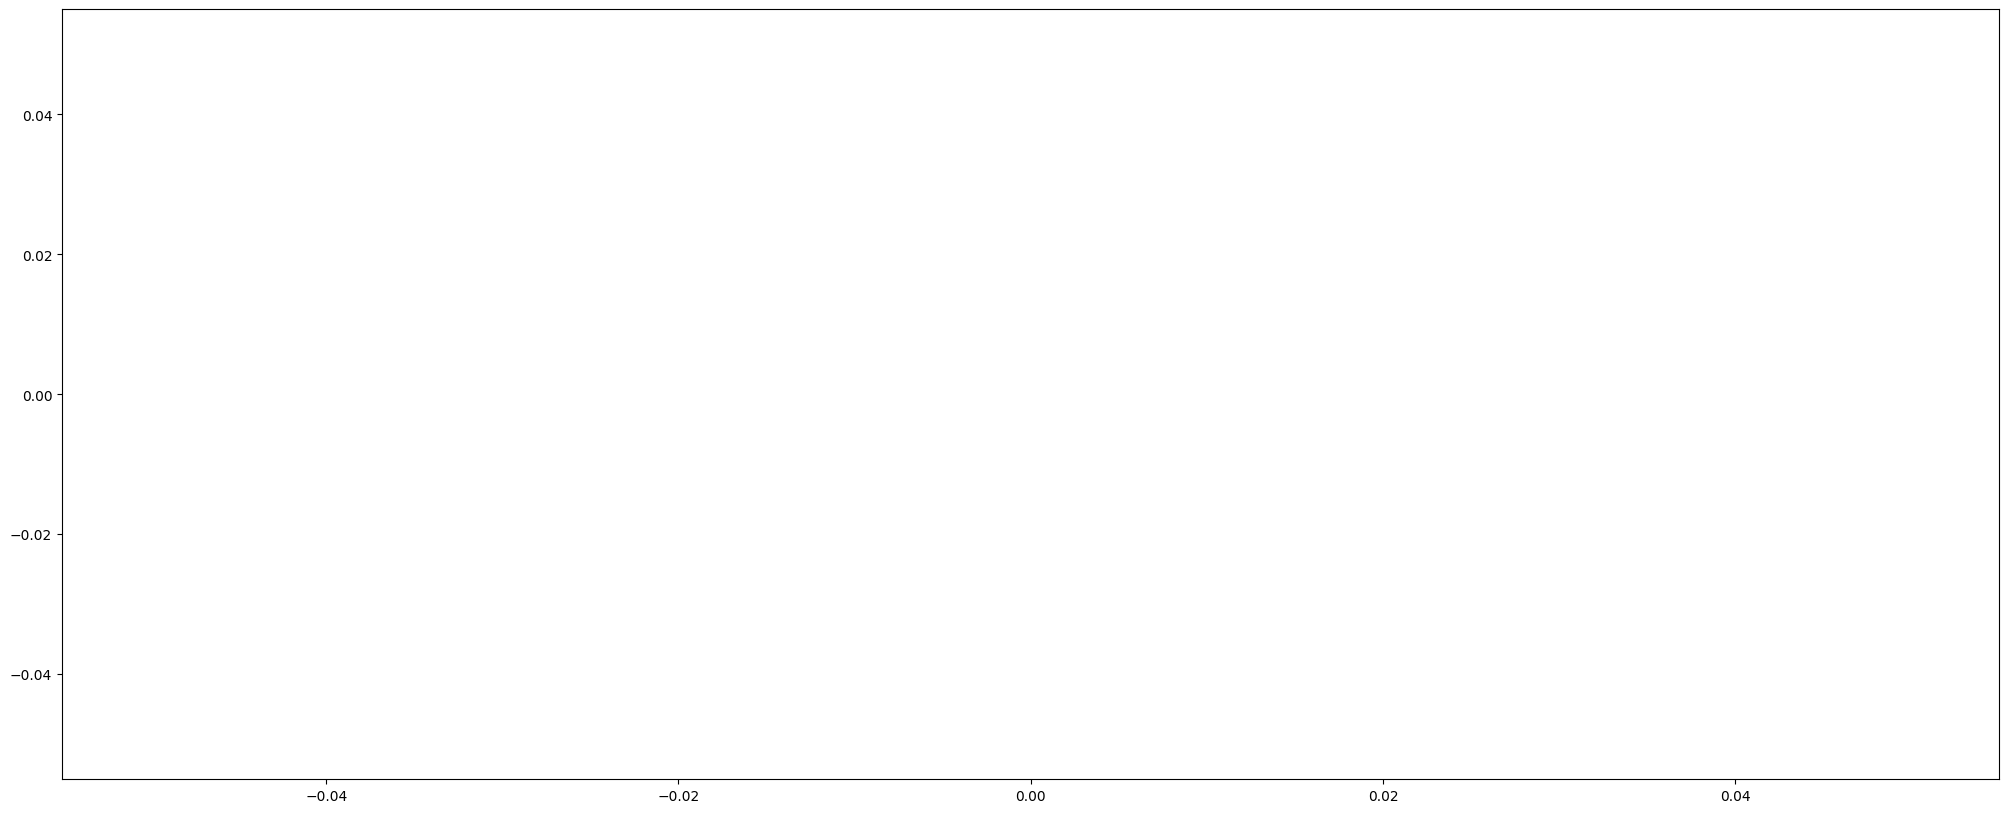

In [30]:
plt.figure(figsize = (25,10))
plt.plot(losses)

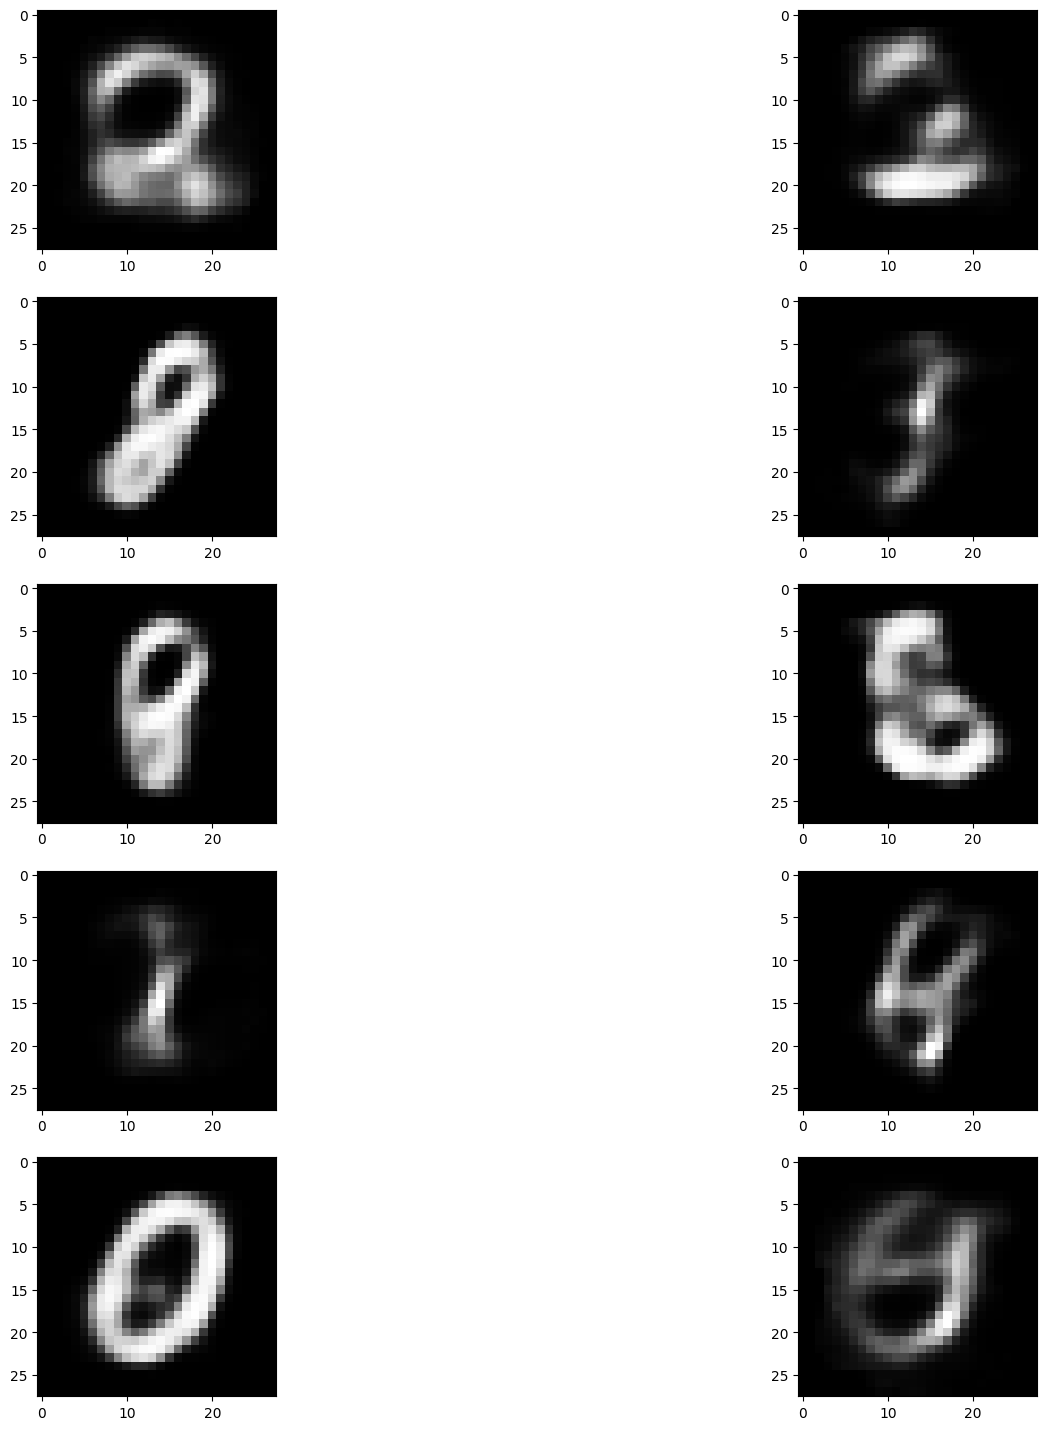

In [201]:
z = torch.randn((10, 16))
new_images = model.sample(z.to(device))

plt.figure(figsize=(18, 18))
for i in range(new_images.shape[0]):
    plt.subplot(new_images.shape[0] // 2, 2, i + 1)
    generated = new_images[i].cpu().detach().numpy()
    plt.imshow(generated, cmap = 'gray')

plt.show()